# Breast Cancer Gene Expression Analysis

This notebook performs a full exploratory and statistical analysis of gene expression data to identify the most differentially expressed probe sets between `cancer` and `normal` samples.

Steps include:
- Dataset preparation
- Exploratory data analysis (EDA)
- Differential expression analysis (log2 fold change, t-tests)
- Visualization of top features (boxplots, PCA)
- Export of final ranked summary


## Dataset preparation

The dataset contains gene expression values from various breast tissue samples.  
Each sample is labeled by type (e.g., `normal`, `basal`, `HER2`, `luminal`, etc.).

Steps performed:
- The dataset was loaded from a CSV file.
- Samples labeled as `cell_line` were removed to ensure biological relevance.
- A binary `group` column was created:`normal` for healthy tissue, `cancer` for all tumor subtypes.
- Group distribution was visualized to assess class balance.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [3]:
# Load the dataset
df = pd.read_csv("/kaggle/input/breast-cancer-gene-expression-cumida/Breast_GSE45827.csv")

# Display basic shape and column info
print("Shape:", df.shape)
df.head(3)


Shape: (151, 54677)


,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,...,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
1,85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,...,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
2,87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,...,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535


In [4]:
# Remove "cell_line" samples
df = df[df["type"].str.lower() != "cell_line"]

# Create binary group column: "normal" vs "cancer"
df["group"] = df["type"].apply(lambda x: "normal" if x.lower() == "normal" else "cancer")

# Check class distribution
df["group"].value_counts()


group
cancer    130
normal      7
Name: count, dtype: int64

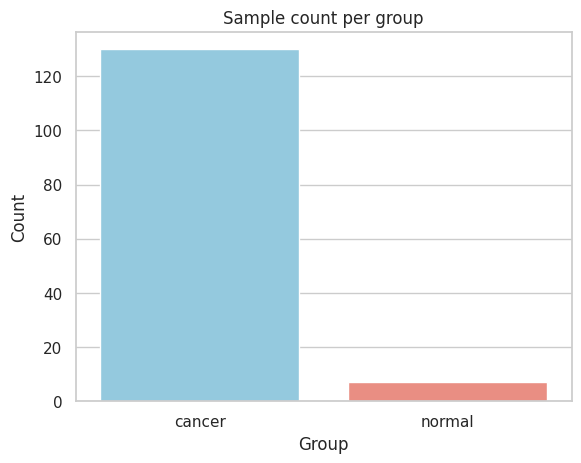

In [7]:
# Plot group counts
sns.countplot(data=df, x="group", palette=["skyblue", "salmon"])
plt.title("Sample count per group")
plt.xlabel("Group")
plt.ylabel("Count")
plt.savefig("/kaggle/working/sample_count_per_group.png", dpi=300, bbox_inches="tight")
plt.show()


## Exploratory data analysis (EDA) and Differential expression analysis

This section includes:
- Visualization of sample counts by group
- Identification of expression patterns in selected probe sets
- Statistical comparison of expression levels between groups
- Calculation of log2 fold change and t-test p-values to identify features that differ significantly between `normal` and `cancer`.

The result is a ranked table of differentially expressed probe sets.


In [8]:
from scipy.stats import ttest_ind

# Separate the data by group
normal_samples = df[df["group"] == "normal"]
cancer_samples = df[df["group"] == "cancer"]

# Select only numeric columns (probe sets)
probe_cols = df.columns[2:-1]  # exclude "samples", "type", "group"

# Create containers for results
results = []

# Loop through each probe to calculate mean, log2FC and p-value
for probe in probe_cols:
    normal_values = normal_samples[probe]
    cancer_values = cancer_samples[probe]

    # Means
    mean_normal = normal_values.mean()
    mean_cancer = cancer_values.mean()

    # Avoid division by zero
    if mean_normal == 0 or mean_cancer == 0:
        continue

    # Log2 Fold Change
    log2fc = np.log2(mean_cancer / mean_normal)

    # T-test
    stat, pval = ttest_ind(cancer_values, normal_values, equal_var=False)

    results.append({
        "probe_id": probe,
        "mean_normal": mean_normal,
        "mean_cancer": mean_cancer,
        "log2FC": log2fc,
        "p_value": pval
    })

# Create a DataFrame with results
results_df = pd.DataFrame(results)

# Sort by absolute log2FC
results_df["abs_log2FC"] = results_df["log2FC"].abs()
results_df = results_df.sort_values(by="abs_log2FC", ascending=False)

# Save the results as a CSV file
results_df.to_csv("/kaggle/working/differential_expression_results.csv", index=False)

# Show top 10
results_df.head(10)


,probe_id,mean_normal,mean_cancer,log2FC,p_value,abs_log2FC
16620,207175_at,11.130027,4.736829,-1.232464,2.503821e-05,1.232464
26713,217428_s_at,4.002313,8.994421,1.168196,3.442948e-39,1.168196
179,1552509_a_at,7.801721,3.485118,-1.162585,4.803564e-04,1.162585
19023,209613_s_at,10.089049,4.598064,-1.133692,9.273542e-05,1.133692
19181,209773_s_at,4.106258,8.945309,1.123307,2.579246e-10,1.123307
39093,229839_at,7.782050,3.580566,-1.119963,1.662616e-05,1.119963
16538,207092_at,9.007475,4.148245,-1.118622,2.088815e-03,1.118622
35403,226147_s_at,11.086991,5.200143,-1.092245,8.178311e-06,1.092245
14159,204712_at,8.695465,4.128921,-1.074498,1.394263e-03,1.074498
45227,235978_at,7.998852,3.799729,-1.073897,1.254027e-03,1.073897


## Visualization of top features

Boxplots were generated for the top 5 differentially expressed probe sets (based on absolute log2 fold change), comparing their expression in `cancer` vs `normal`.

Additionally, PCA was applied using the top 100 most differentially expressed features.  
This dimensionality reduction allows visual assessment of group separation in 2D space.

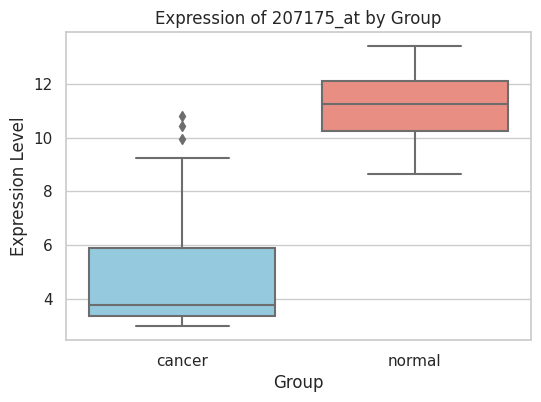

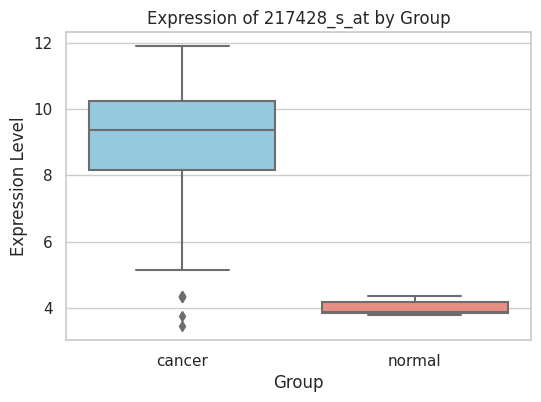

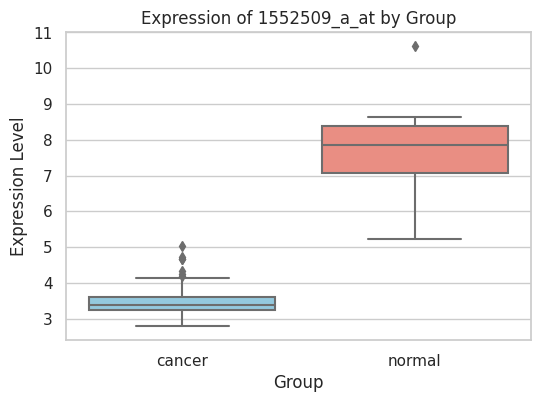

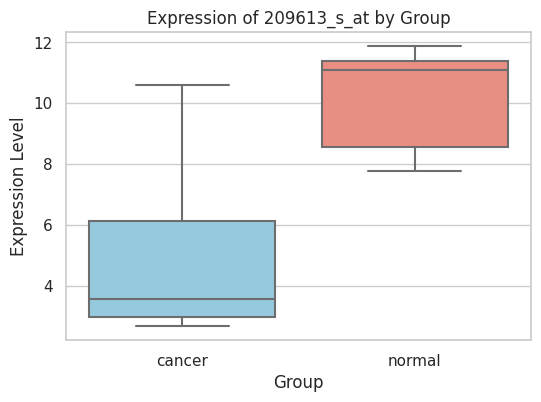

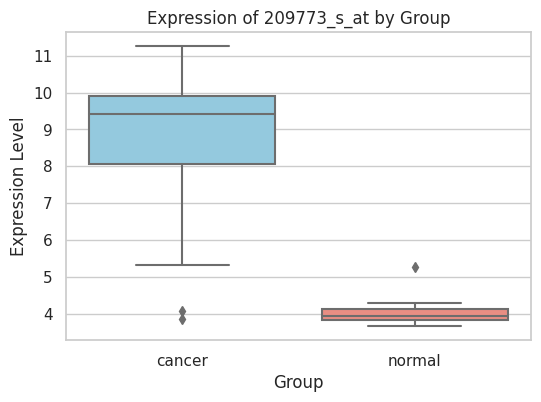

In [9]:
# Select top 5 probes
top5_probes = results_df.head(5)["probe_id"].values

# Set plot style
sns.set(style="whitegrid")

# Loop through and plot each
for probe in top5_probes:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x="group", y=probe, palette=["skyblue", "salmon"])
    plt.title(f"Expression of {probe} by Group")
    plt.xlabel("Group")
    plt.ylabel("Expression Level")
    
    # Save the plot
    filename = f"/kaggle/working/boxplot_{probe}.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    
    plt.show()


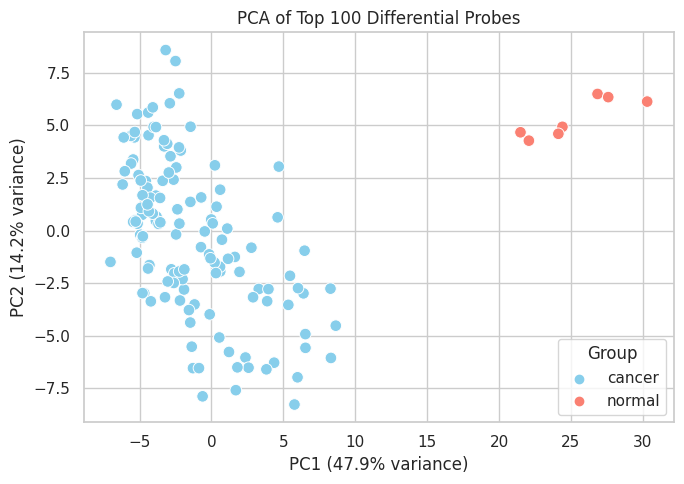

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select top 100 probes by absolute log2FC
top_100_probes = results_df.sort_values(by="abs_log2FC", ascending=False).head(100)["probe_id"].values

# Subset the dataframe to just those probes
X = df[top_100_probes]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results and group info
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["group"] = df["group"].values

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="group", palette=["skyblue", "salmon"], s=70)
plt.title("PCA of Top 100 Differential Probes")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title="Group")
plt.tight_layout()

# Save the figure
plt.savefig("/kaggle/working/pca_top100_log2fc.png", dpi=300)
plt.show()


## Summary and export

The top 20 probe sets with the strongest differences between groups were extracted, based on log2 fold change and statistical significance.

Values were rounded for readability and saved as a CSV summary table.  
This result serves as the final answer to the central question: **Which features most clearly distinguish cancer from normal tissue?**


In [23]:
# Select and format columns
summary_cols = ["probe_id", "mean_normal", "mean_cancer", "log2FC", "p_value"]

summary_df = results_df[summary_cols].copy()
summary_df = summary_df.round({
    "mean_normal": 3,
    "mean_cancer": 3,
    "log2FC": 3,
    "p_value": 3
})

# Sort by absolute log2FC
summary_df["abs_log2FC"] = results_df["log2FC"].abs()
summary_df = summary_df.sort_values(by="abs_log2FC", ascending=False)

# Get top 20 features
top_summary = summary_df.head(20).drop(columns="abs_log2FC").reset_index(drop=True)

# Display nicely styled table
from IPython.display import display

styled_table = top_summary.style \
    .set_caption("Top 20 Differentially Expressed Probe Sets") \
    .format({
        "mean_normal": "{:.3f}",
        "mean_cancer": "{:.3f}",
        "log2FC": "{:.3f}",
        "p_value": "{:.3e}"
    }) \
    .background_gradient(subset=["log2FC"], cmap="coolwarm") \
    .hide(axis="index")

display(styled_table)

# Export to CSV
top_summary.to_csv("/kaggle/working/top20_differential_probes.csv", index=False)


probe_id,mean_normal,mean_cancer,log2FC,p_value
207175_at,11.130,4.737,-1.232,0.000e+00
217428_s_at,4.002,8.994,1.168,0.000e+00
1552509_a_at,7.802,3.485,-1.163,0.000e+00
209613_s_at,10.089,4.598,-1.134,0.000e+00
209773_s_at,4.106,8.945,1.123,0.000e+00
229839_at,7.782,3.581,-1.120,0.000e+00
207092_at,9.007,4.148,-1.119,2.000e-03
226147_s_at,11.087,5.200,-1.092,0.000e+00
204712_at,8.695,4.129,-1.074,1.000e-03
235978_at,7.999,3.800,-1.074,1.000e-03


## Interpretation

This analysis identified the top 20 probe sets with the strongest expression differences between cancer and normal breast tissue samples.

Key findings:

- Several probes showed a **log2 fold change greater than ±1**, indicating at least a **2-fold difference** in expression.
- Many of these differences were **statistically significant** (p-value < 0.001), based on independent t-tests.
- The top features clearly distinguish cancer samples from normal ones, as confirmed by:
  - **Boxplot visualizations** of expression levels
  - **PCA plots**, showing clear separation between groups in reduced dimensional space

These probe sets could serve as a foundation for further analysis, such as:
- Feature selection for classification models
- Biological interpretation or mapping to known genes
- Visualization in dashboards (e.g., Looker)

The complete summary table has been exported as a CSV file and can be reused in downstream tasks.
